Importing Libraries

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# Using matplotlib to display the images
def display_images(images, titles, cmap='gray'):
    plt.figure(figsize=(30, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

## 1

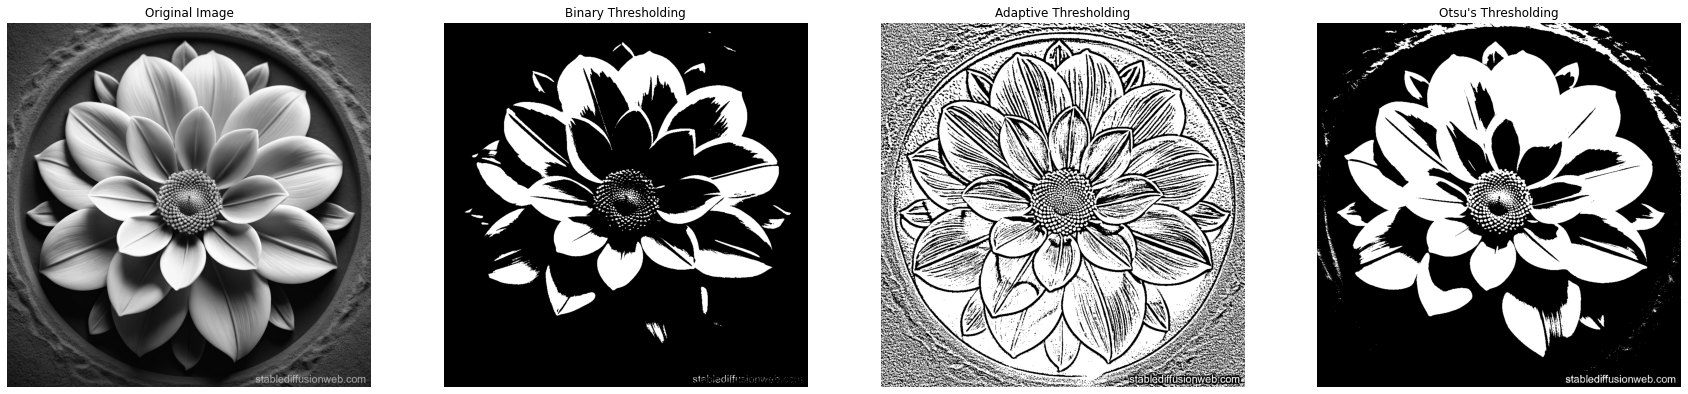

In [74]:
# Reading the grayscale image
image = cv2.imread('images/greyscale.jpg', cv2.IMREAD_GRAYSCALE)
# Applying binary thresholding: pixels above 180 are set to 255 (white), others to 0 (black)
_, binary_thresh = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)
# Applying adaptive thresholding: the threshold value is calculated for small regions of the image
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
# Applying Otsu's thresholding: an optimal threshold value is determined automatically by minimizing intra-class variance
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Titles are provided for each image to identify the corresponding thresholding technique
display_images([image, binary_thresh, adaptive_thresh, otsu_thresh],
               ["Original Image", "Binary Thresholding", "Adaptive Thresholding", "Otsu's Thresholding"])

Otsu's thresholding appears to provide the best segmentation. It maintains clear, well-defined petal boundaries similar to the binary thresholding method, but handles the darker regions and center of the flower more effectively with less noise and better preservation of the flower's natural structure compared to both binary and adaptive thresholding, where adaptive thresholding introduced excessive edge artifacts and noise in the segmentation and simple binary thresholding has unwanted dark regions.

## 2

In [75]:
# Function to detect lines using Hough Transform
def hough_lines(img, threshold=100):
    # Applying the Hough Transform to detect lines in the image
    # The function returns a list of lines, where each line is represented by (rho, theta)
    lines = cv2.HoughLines(img, 1, np.pi / 180, threshold)
    # Creating a copy of the original image to draw the lines on
    line_img = np.copy(image)
    # If lines are detected, iterate through each line and draw it
    if lines is not None:
        for line in lines:
            # Extracting rho and theta values for each line
            rho, theta = line[0]
            # Computing the cos and sin of theta to calculate the line's direction
            a = np.cos(theta)
            b = np.sin(theta)
            # Calculating the line's point of intersection with the origin (x0, y0)
            x0 = a * rho
            y0 = b * rho
            # Calculating two points on the line (x1, y1) and (x2, y2)
            # These points are extended by a factor of 1000 to ensure the line is drawn properly
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            # Drawing the line on the image using the calculated points
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    # Returning the image with the drawn lines
    return line_img


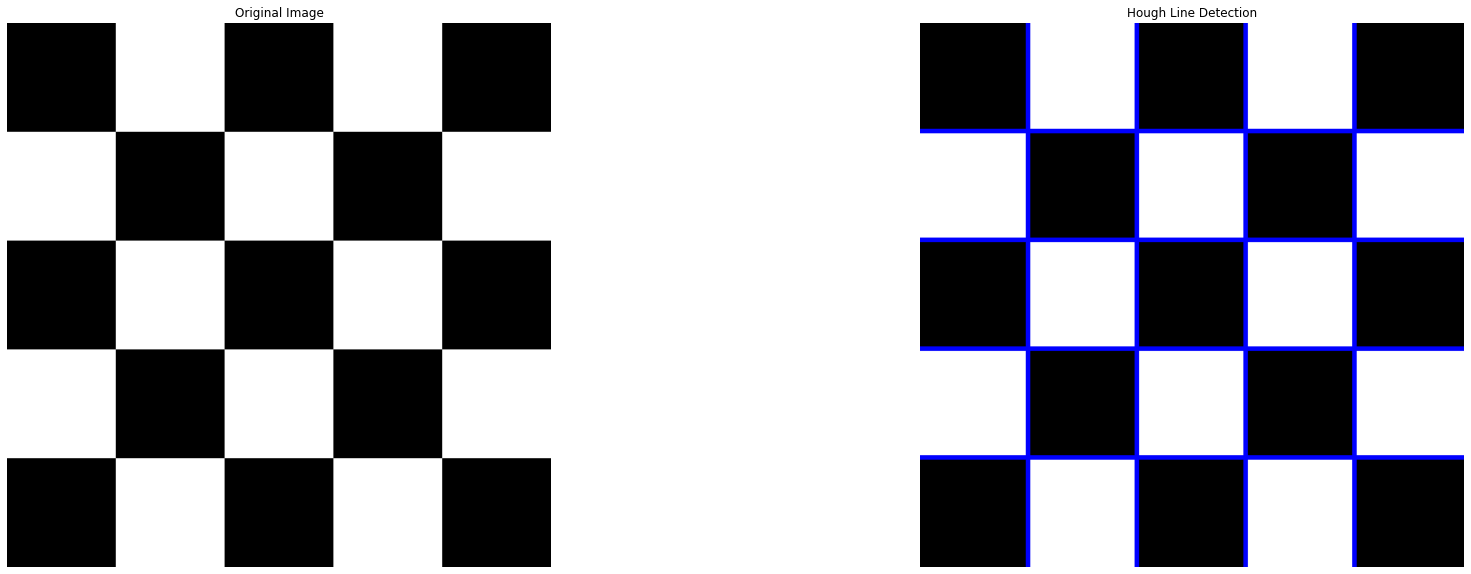

In [76]:
# Reading the checkerboard image
image = cv2.imread('images/checkerboard.png')
# Converting the image to grayscale, as edge detection works on single-channel images
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Applying the Canny edge detection algorithm to detect edges in the grayscale image
# apertureSize=3 refers to the size of the Sobel kernel used for edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Applying the Hough Transform to detect lines in the edge-detected image
line_image = hough_lines(edges)
# Displaying the original image and the image with detected lines
display_images([image, line_image], ["Original Image", "Hough Line Detection"])

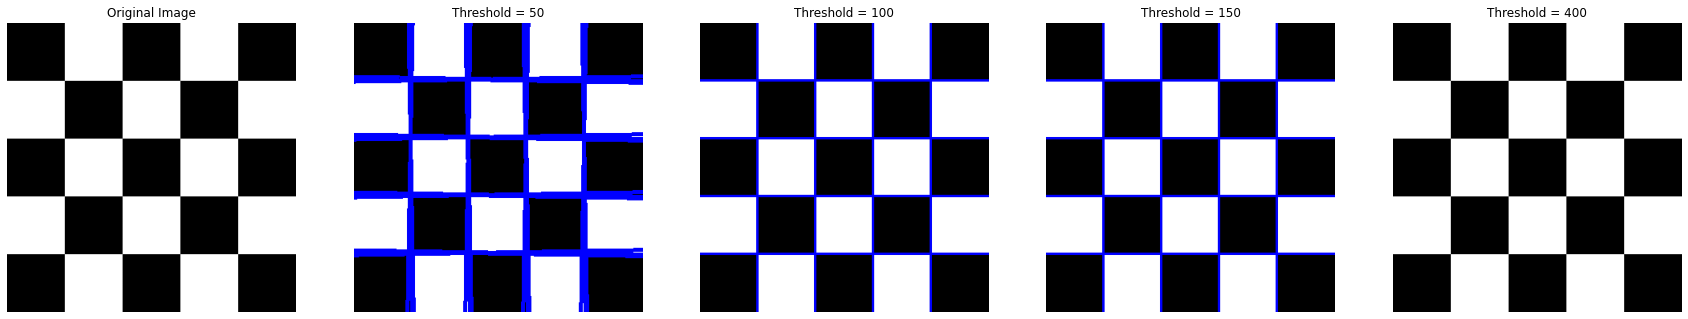

In [77]:
# Defining threshold values for Hough line detection
thresholds = [50, 100, 150, 400]
# Lists to store the resulting images and labels
results = []
labels = []
# Loop through each threshold value and apply Hough transform
for threshold in thresholds:
    line_image = hough_lines(edges, threshold=threshold)
    results.append(line_image)
    labels.append(f"Threshold = {threshold}")
# Display the original image and the results for each threshold
display_images([image] + results, ["Original Image"] + labels, cmap=None)

As the Hough Transform threshold increases (from 50 to 200), fewer lines are detected in the checkerboard image. A lower threshold (e.g., 50) detects more lines, including some weaker ones, while a higher threshold (e.g., 150) filters out less prominent lines, resulting in cleaner but sparser detection, while a threshold of 400 does not detect edges at all. This demonstrates the trade-off between sensitivity and noise in line detection.


## 3

In [78]:
# Hough Circle Detection function
def hough_circles(
    img, dp=1.2, minDist=800, param1=90, param2=50, minRadius=300, maxRadius=400
):
    # Apply HoughCircles to detect circles
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        dp,
        minDist,
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius,
    )
    # Convert grayscale image to color for visualization
    circle_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # If circles are detected, draw them
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for x, y, r in circles:
            # Draw the circle
            cv2.circle(circle_img, (x, y), r, (0, 255, 0), 10)
            # Draw a rectangle at the center of the circle
            cv2.rectangle(circle_img, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    # Return the image with circles drawn
    return circle_img

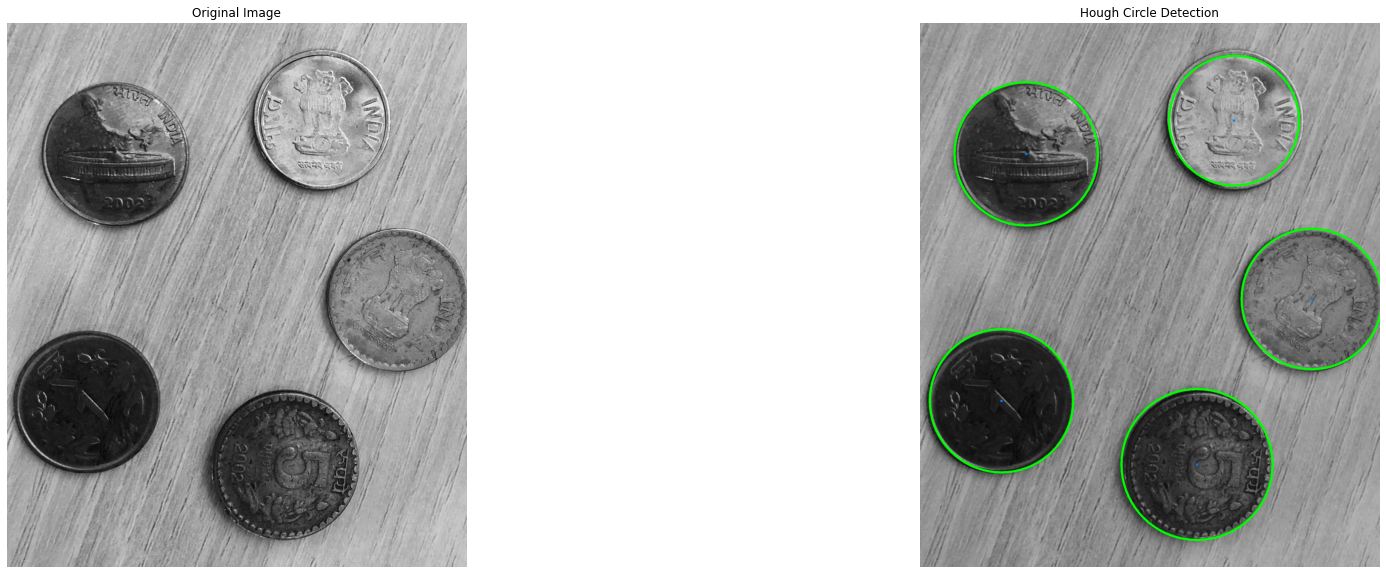

In [79]:
# Load and preprocess the image
image = cv2.imread('images/coins.jpg', cv2.IMREAD_GRAYSCALE)
# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image, (7, 7), 0)
# Detect circles using Hough Transform
circle_image = hough_circles(blurred)
# Display original and processed images
display_images([image, circle_image], ["Original Image", "Hough Circle Detection"])

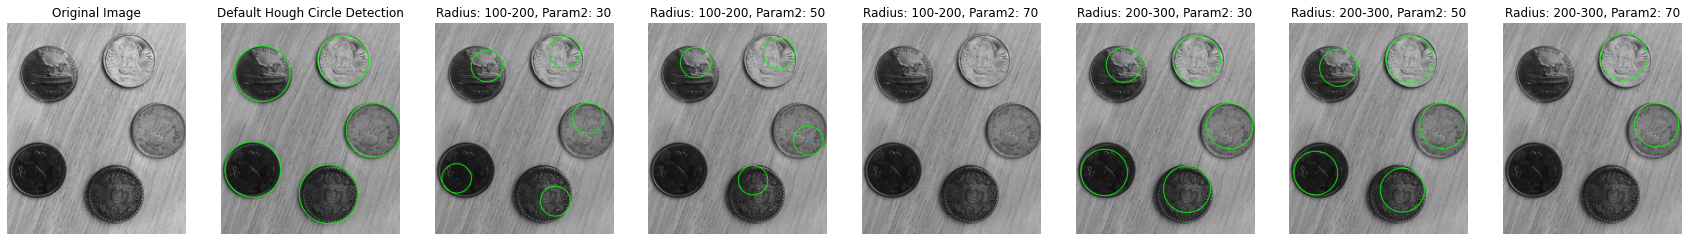

In [80]:
# Define radius ranges and param2 values to experiment with
radius_ranges = [(100, 200), (200, 300)]
param2_values = [30, 50, 70]
# Initialize lists to store results and labels
results = []
labels = []
# Loop through the parameter combinations
for minRadius, maxRadius in radius_ranges:
    for param2 in param2_values:
        # Detect circles with the current parameters
        adjusted_circle_image = hough_circles(
            blurred, minRadius=minRadius, maxRadius=maxRadius, param2=param2
        )
        # Append the result and label
        results.append(adjusted_circle_image)
        labels.append(f"Radius: {minRadius}-{maxRadius}, Param2: {param2}")
# Display original and adjusted circle detection results
display_images(
    [image, circle_image] + results,
    ["Original Image", "Default Hough Circle Detection"] + labels
)

Observations on Improvements  
Radius Adjustments:  
Improved detection for circles within specified size ranges.  
Smaller ranges (e.g., 100-200) captured small circles, while larger ranges (e.g., 200-300) focused on bigger coins.  
Param2 Adjustments:  
Lower param2 (e.g., 30) detected faint edges but increased false positives.  
Higher param2 (e.g., 70) reduced false positives, improving precision.  
Overall: Fine-tuning minRadius, maxRadius, and param2 yielded better accuracy and reduced misdetections compared to default parameters.  

## 4

In [81]:
# Harris corner detection function
def harris_corners(img, block_size=2, ksize=3, k=0.04):
    # Apply the Harris corner detection algorithm
    dst = cv2.cornerHarris(img, block_size, ksize, k)
    # Dilate the corner points to enhance visibility
    dst = cv2.dilate(dst, None)
    # Copy the input image and convert it to color
    corner_img = np.copy(img)
    corner_img = cv2.cvtColor(corner_img, cv2.COLOR_GRAY2BGR)
    # Mark the detected corners with red color
    corner_img[dst > 0.01 * dst.max()] = [0, 0, 255]
    # Return the image with highlighted corners
    return corner_img


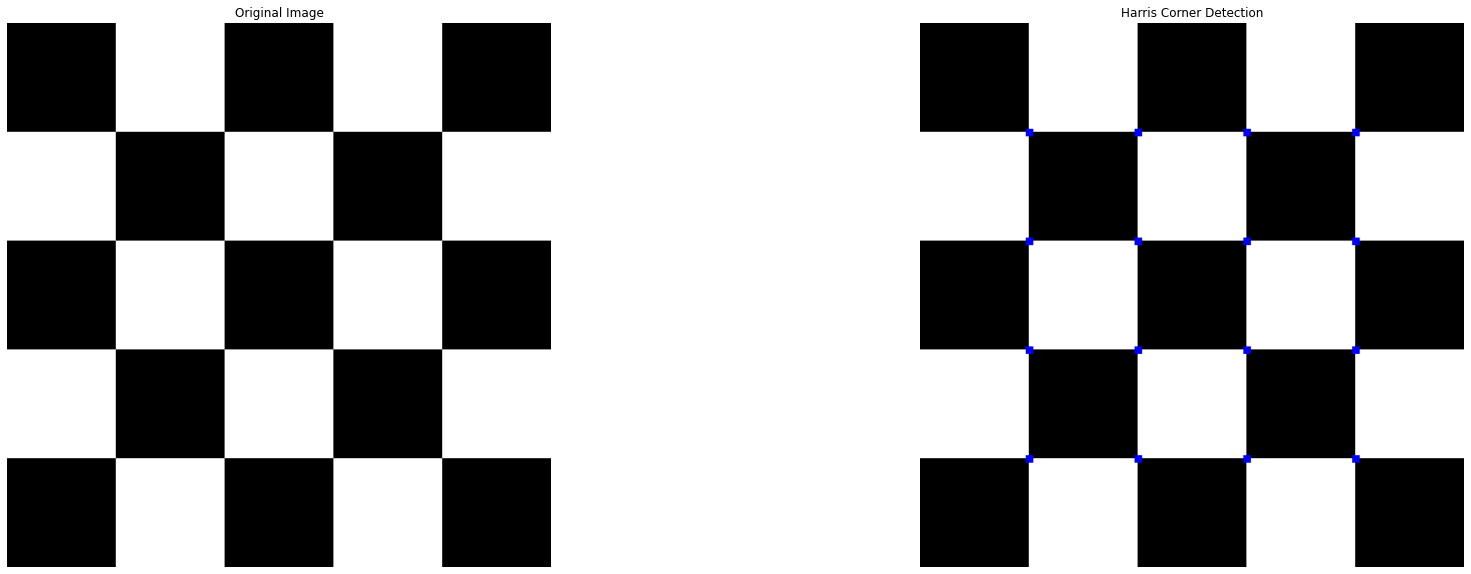

In [82]:
# Load the checkerboard image
image = cv2.imread('images/checkerboard.png')
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Apply Harris corner detection on the grayscale image
corner_image = harris_corners(gray)
# Display the original image and the image with detected corners
display_images([image, corner_image], ["Original Image", "Harris Corner Detection"])

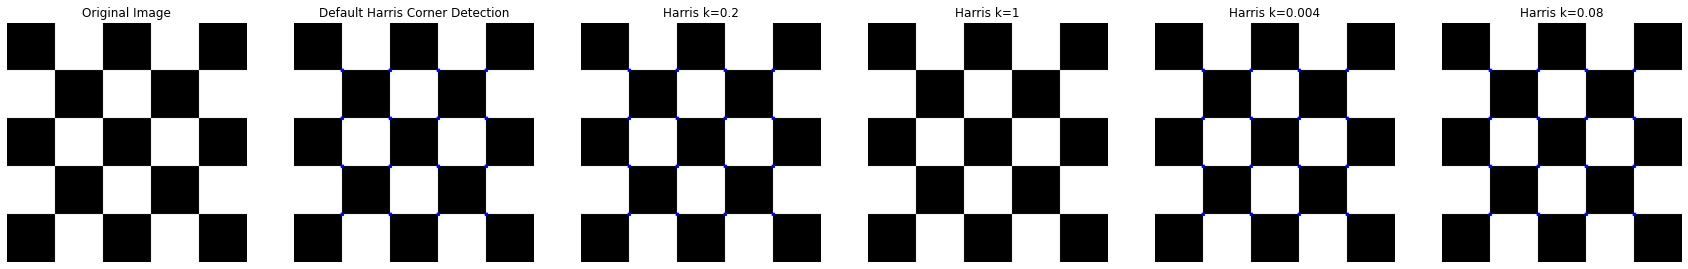

In [83]:
# Define different k values for Harris corner detection
k_values = [0.2, 1, 0.004, 0.08]
corner_results = []
corner_labels = []
# Loop through each k value and apply Harris corner detection
for k in k_values:
    adjusted_corner_image = harris_corners(gray, k=k)
    corner_results.append(adjusted_corner_image)
    corner_labels.append(f"Harris k={k}")
# Display the original image, default corner detection, and results for each k value
display_images(
    [image, corner_image] + corner_results,
    ["Original Image", "Default Harris Corner Detection"] + corner_labels
)

Based on the images showing Harris Corner Detection with varying k values (0.2, 1, 0.004, and default), the sensitivity parameter k significantly influences corner detection performance on the checkerboard pattern. When k=0.004 (lower value), the detector becomes more sensitive and identifies more corner points, while higher k values (k=1) result in fewer detected corners, demonstrating that the k parameter effectively controls the detector's selectivity - with smaller values leading to more corner detections and larger values producing more conservative results with fewer detected corners.  

## 5

The Hough Transform is a powerful technique used to detect geometric shapes in images, and its implementation varies significantly when detecting lines versus circles. These differences arise primarily from variations in parameter space and computational complexity.

For line detection, the parameter space is two-dimensional, defined by ρρ (the perpendicular distance of the line from the origin) and θθ (the angle of inclination). Each edge pixel in the image votes for all potential lines that can pass through it, accumulating votes in a 2D accumulator array. Peaks in this array indicate the presence of lines. This relatively simple 2D parameter space makes line detection computationally efficient, even for large images, as it requires fewer computations per pixel.

In contrast, circle detection involves a three-dimensional parameter space. Circles are defined by xx, yy (the center coordinates), and rr (the radius). Each edge pixel votes for multiple potential circles that can pass through it. This increases the size of the accumulator and the computational burden. For optimization, rr is often fixed, or gradient information is used to constrain the possible center coordinates, reducing computational overhead.

In summary, while line detection is faster and simpler due to its lower dimensionality, circle detection is more complex and computationally intensive because of the added radius parameter.